In [1]:
import os, sys
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomZoom, RandomContrast, RandomRotation
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, Dropout
from tensorflow_addons.metrics import F1Score
import tensorflow_datasets as tfds
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


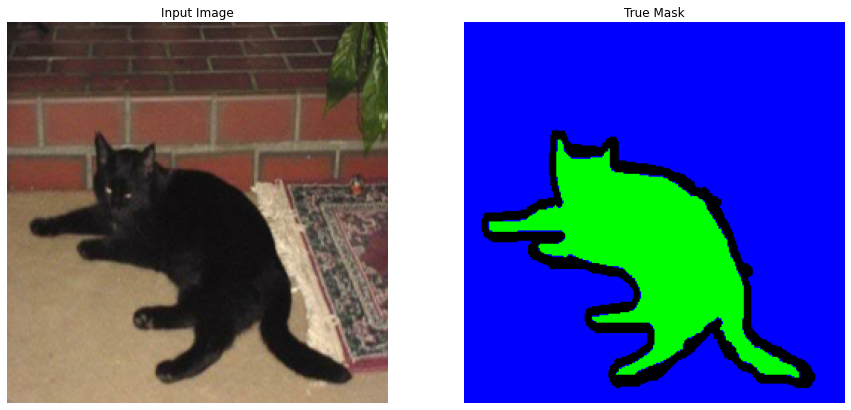

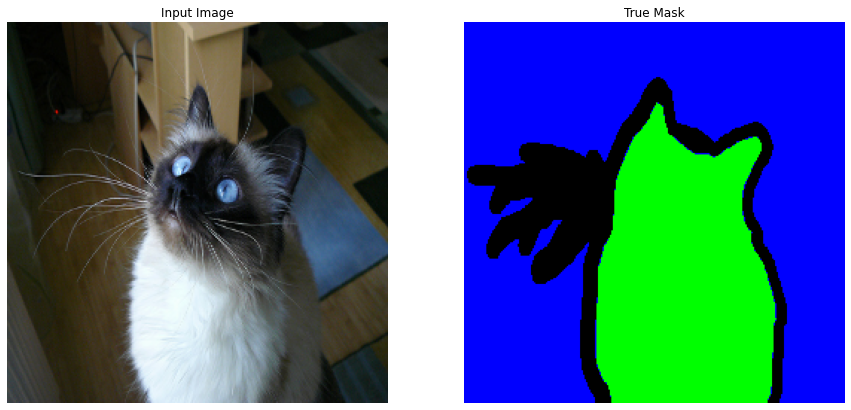

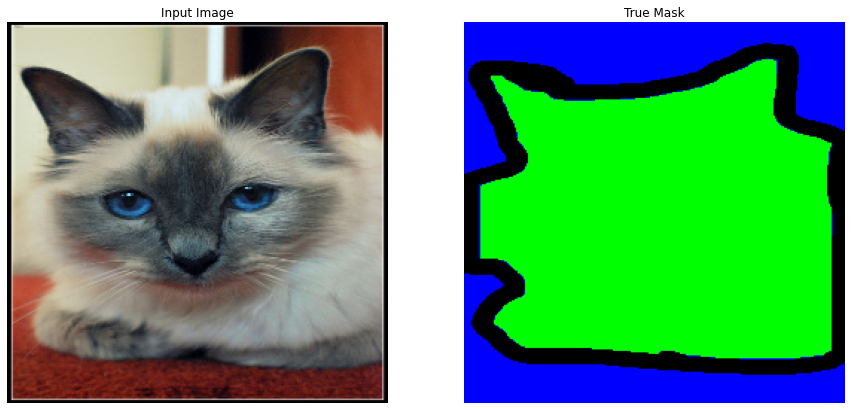

In [2]:
batch_size = 16
img_height, img_width = 256, 256
no_classes = 3
(train, val, test), ds_info = tfds.load('oxford_iiit_pet', with_info=True, shuffle_files=True, split=['train', 'test[:50%]', 'test[50%:]'])

def preprocess(datapoint):
    img = tf.image.resize(datapoint['image'], (img_height, img_width))
    mask = tf.image.resize(datapoint['segmentation_mask'], (img_height, img_width))
    return img, tf.squeeze(tf.cast(tf.one_hot(tf.cast(mask, tf.int64), no_classes), tf.float32))  # per pixel one hot encoding

train = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(preprocess)
test = test.map(preprocess)

train_ds = train.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in test.take(3):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [3]:
def U_net(input_size, no_classes, start_filter_no, kernel_initializer, bn_eps, opt, loss, reg, metrics):
    def down_conv_block(x, filter, kernel, bn_eps, kernel_initializer, block_no):
        x = Conv2D(filter, kernel, kernel_initializer=kernel_initializer, kernel_regularizer=reg, padding='same', name=f'blk_{block_no}_Conv2D_1')(x)
        x = BatchNormalization(epsilon=bn_eps, name=f'blk_{block_no}_BN_1')(x)
        x = Activation('relu', name=f'blk_{block_no}_ReLu_1')(x)

        x = Conv2D(filter, kernel, kernel_initializer=kernel_initializer, kernel_regularizer=reg, padding='same', name=f'blk_{block_no}_Conv2D_2')(x)
        x = BatchNormalization(epsilon=bn_eps, name=f'blk_{block_no}_BN_2')(x)
        x = Activation('relu', name=f'blk_{block_no}_ReLu_2')(x)
        # x = Dropout(0.5, name=f'blk_{block_no}_Dropout')(x)

        return x

    def up_conv_block(x, x_short, filter, kernel, bn_eps, kernel_initializer, reg, block_no):
        x = Conv2DTranspose(filter, kernel, kernel_initializer=kernel_initializer, kernel_regularizer=reg, strides=2, padding="same", name=f'blk_{block_no}_Conv2DTranspose')(x)
        x = concatenate([x, x_short], name=f'blk_{block_no}_concatenate')
        # x = Dropout(0.5, name=f'blk_{block_no}_Dropout')(x)

        x = Conv2D(filter, kernel, kernel_initializer=kernel_initializer, kernel_regularizer=reg, padding='same', name=f'blk_{block_no}_Conv2D_1')(x)
        x = BatchNormalization(epsilon=bn_eps, name=f'blk_{block_no}_BN_1')(x)
        x = Activation('relu', name=f'blk_{block_no}_ReLu_1')(x)

        x = Conv2D(filter, kernel, kernel_initializer=kernel_initializer, kernel_regularizer=reg, padding='same', name=f'blk_{block_no}_Conv2D_2')(x)
        x = BatchNormalization(epsilon=bn_eps, name=f'blk_{block_no}_BN_2')(x)
        x = Activation('relu', name=f'blk_{block_no}_ReLu_2')(x)

        return x

    def aug(x):
        x = RandomFlip("horizontal_and_vertical")(x)
        x = RandomContrast(0.2)(x)
        x = RandomRotation(0.2)(x)
        x = RandomZoom(0.2)(x)
        return x

    xInput = Input(input_size)
    x = Rescaling(1./255)(xInput)  # fit 0-255 into 0 and 1
    # x = aug(x)

    # Increment the power of 2 each block down
    x_short_1 = down_conv_block(x, start_filter_no * 2 ** 0, 3, bn_eps, kernel_initializer=kernel_initializer, block_no=0)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_short_1)

    x_short_2 = down_conv_block(x, start_filter_no * 2 ** 1, 3, bn_eps, kernel_initializer=kernel_initializer, block_no=1)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_short_2)

    x_short_3 = down_conv_block(x, start_filter_no * 2 ** 2, 3, bn_eps, kernel_initializer=kernel_initializer, block_no=2)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_short_3)

    x_short_4 = down_conv_block(x, start_filter_no * 2 ** 3, 3, bn_eps, kernel_initializer=kernel_initializer, block_no=3)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_short_4)

    x = down_conv_block(x, start_filter_no * 2 ** 4, 3, bn_eps, kernel_initializer=kernel_initializer, block_no=4)
    x = Dropout(0.5, name=f'Bridge_Dropout')(x)

    x = up_conv_block(x, x_short_4, start_filter_no * 2 ** 3, 3, bn_eps, kernel_initializer=kernel_initializer, reg=reg, block_no=5)
    x = up_conv_block(x, x_short_3, start_filter_no * 2 ** 2, 3, bn_eps, kernel_initializer=kernel_initializer, reg=reg, block_no=6)
    x = up_conv_block(x, x_short_2, start_filter_no * 2 ** 1, 3, bn_eps, kernel_initializer=kernel_initializer, reg=reg, block_no=7)
    x = up_conv_block(x, x_short_1, start_filter_no * 2 ** 0, 3, bn_eps, kernel_initializer=kernel_initializer, reg=reg, block_no=8)

    x = Conv2D(no_classes, 1, kernel_initializer=kernel_initializer, kernel_regularizer=reg, padding="same")(x)  # no_classes is the total no of classes present in the train data, including background
    x = BatchNormalization(epsilon=bn_eps)(x)
    xOutput = Activation('softmax')(x)

    model = Model(xInput, xOutput)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model


def dice(y_true, y_pred, smooth=1e-6):
  numerator = 2. * tf.reduce_sum(y_true * y_pred) + smooth
  denominator = tf.reduce_sum(y_true + y_pred) + smooth
  return tf.reduce_mean(numerator / denominator)

def dice_loss(y_true, y_pred):
    return 1 - dice(y_true, y_pred)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
blk_0_Conv2D_1 (Conv2D)         (None, 256, 256, 32) 896         rescaling_2[0][0]                
__________________________________________________________________________________________________
blk_0_BN_1 (BatchNormalization) (None, 256, 256, 32) 128         blk_0_Conv2D_1[0][0]             
____________________________________________________________________________________________

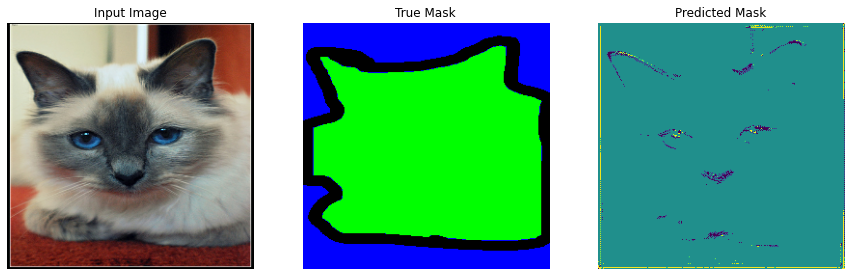

In [9]:
lr = 1e-3
epsilon = 1e-6
opt = keras.optimizers.Adam(learning_rate=lr, epsilon=epsilon)
# opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.99)
loss = dice_loss
reg = None
metrics = [dice]  # keras.metrics.MeanIoU(num_classes=no_classes), F1Score(num_classes=no_classes)
epoch = 100
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice', min_delta=0, patience=10, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_dice',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice', factor=0.1, patience=3, verbose=1),
    DisplayCallback()]

# input size must be 2 to the power of sth, no_classes is same the total no of classes present in the train data, including background
# TODO: try init random
model = U_net(input_size=(img_height, img_width, 3), no_classes=no_classes, start_filter_no=32, kernel_initializer=GlorotUniform, bn_eps=1.001e-5, opt=opt, loss=loss, reg=reg, metrics=metrics)
# model = keras.models.load_model('oxford pet u net 64', custom_objects={'dice': dice, 'dice_loss': dice_loss})
# K.set_value(model.optimizer.lr, lr)
model.summary()
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='U Net.png')
show_predictions()

Epoch 1/100
  6/230 [..............................] - ETA: 49s - loss: 0.6404 - dice: 0.3596 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.2127s). Check your callbacks.


230/230 [==============================] - 60s 254ms/step - loss: 0.4370 - dice: 0.5630 - val_loss: 0.4389 - val_dice: 0.5610

INFO:tensorflow:Assets written to: .\best_model\assets


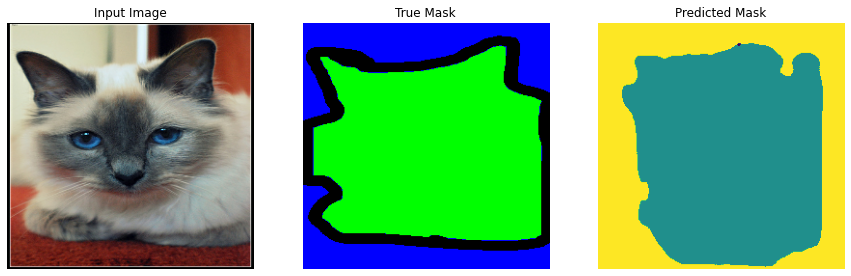


Sample Prediction after epoch 1

Epoch 2/100
230/230 [==============================] - 58s 254ms/step - loss: 0.3211 - dice: 0.6789 - val_loss: 0.3650 - val_dice: 0.6349

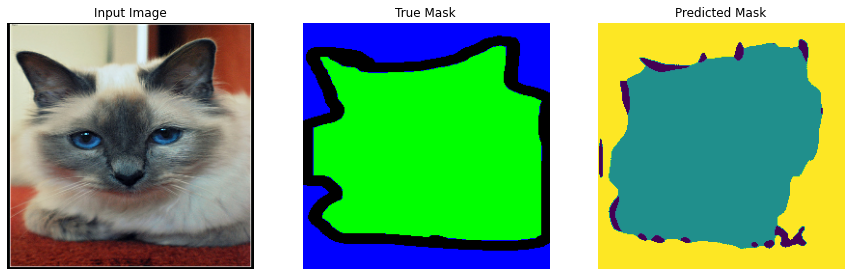


Sample Prediction after epoch 2

Epoch 3/100
230/230 [==============================] - 59s 257ms/step - loss: 0.2582 - dice: 0.7418 - val_loss: 0.2823 - val_dice: 0.7176

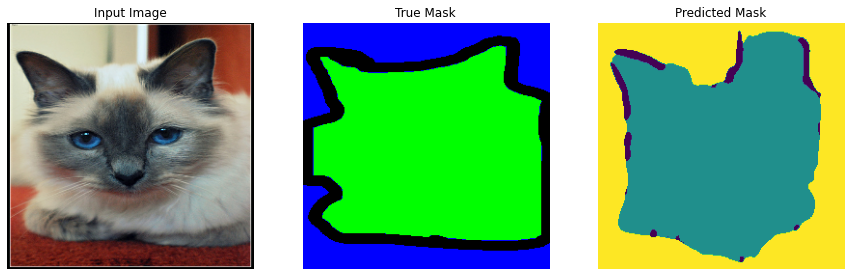


Sample Prediction after epoch 3

Epoch 4/100
230/230 [==============================] - 60s 262ms/step - loss: 0.2181 - dice: 0.7819 - val_loss: 0.3319 - val_dice: 0.6681

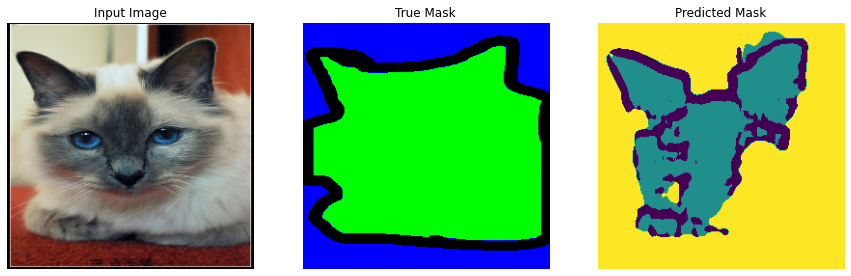


Sample Prediction after epoch 4

Epoch 5/100
230/230 [==============================] - 60s 260ms/step - loss: 0.1895 - dice: 0.8105 - val_loss: 0.1876 - val_dice: 0.8124

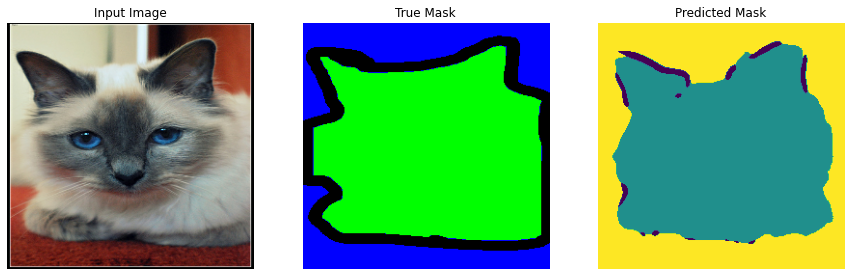


Sample Prediction after epoch 5

Epoch 6/100
230/230 [==============================] - 60s 263ms/step - loss: 0.1829 - dice: 0.8171 - val_loss: 0.1817 - val_dice: 0.8183

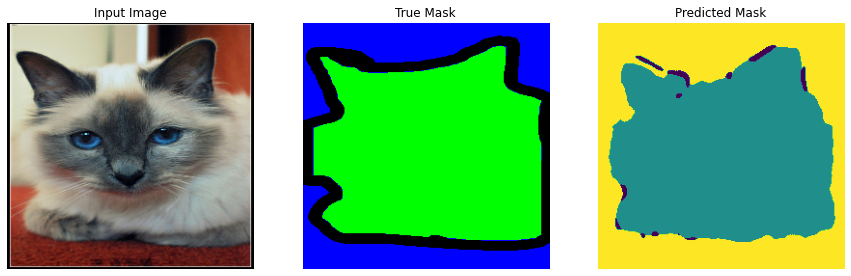


Sample Prediction after epoch 6

Epoch 7/100
230/230 [==============================] - 59s 258ms/step - loss: 0.1769 - dice: 0.8231 - val_loss: 0.1787 - val_dice: 0.8213

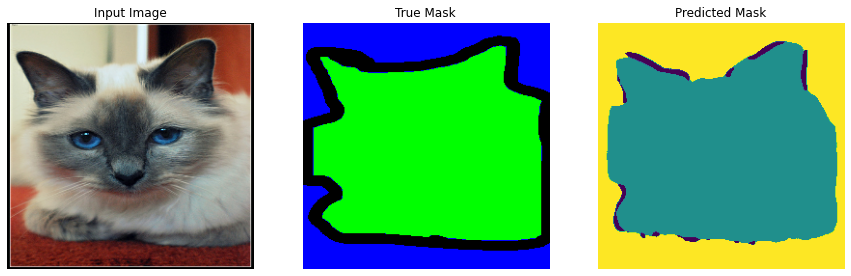


Sample Prediction after epoch 7

Epoch 8/100
230/230 [==============================] - 59s 257ms/step - loss: 0.1723 - dice: 0.8277 - val_loss: 0.1740 - val_dice: 0.8260

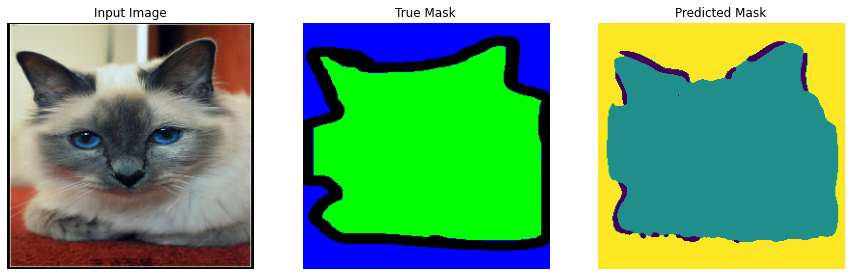


Sample Prediction after epoch 8

Epoch 9/100
230/230 [==============================] - 59s 256ms/step - loss: 0.1723 - dice: 0.8277 - val_loss: 0.1735 - val_dice: 0.8265

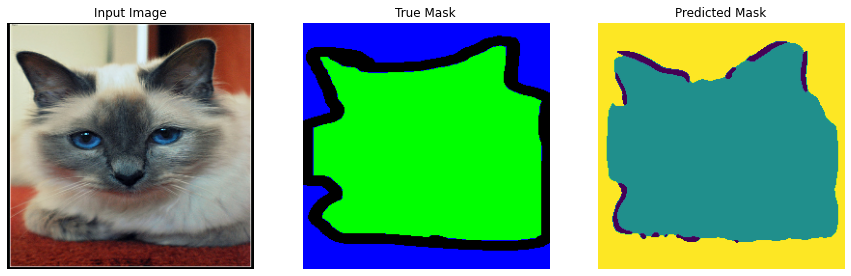


Sample Prediction after epoch 9

Epoch 10/100
230/230 [==============================] - 59s 257ms/step - loss: 0.1705 - dice: 0.8295 - val_loss: 0.1733 - val_dice: 0.8268

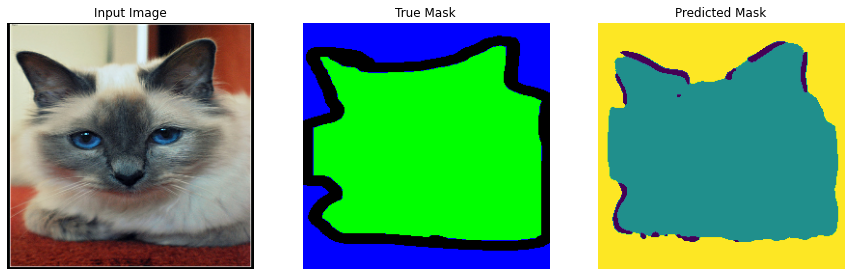


Sample Prediction after epoch 10

Epoch 11/100
230/230 [==============================] - 58s 253ms/step - loss: 0.1704 - dice: 0.8296 - val_loss: 0.1725 - val_dice: 0.8276

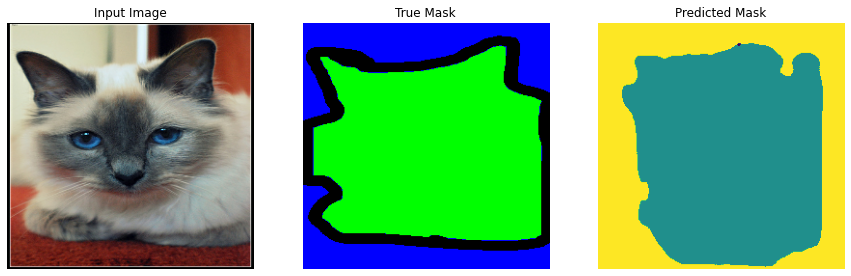


Sample Prediction after epoch 11

Epoch 00011: early stopping


In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch, callbacks=callbacks, verbose=1)

In [6]:
model.evaluate(test_ds)  # 64 test dice 0.8590
model.save('oxford pet u net 64')


115/115 [==============================] - 9s 77ms/step - loss: 0.5135 - dice: 0.4865

INFO:tensorflow:Assets written to: oxford pet u net 64\assets
